### > Задания
Вы – продуктовый дата-аналитик в авто классифайде. В компанию пришел новый дизайнер и предложил освежить дизайн карточки объявления, которая не менялась за последние 6 лет. Ваша задача – проследить за метрикой конверсии из просмотра карточки объявления в контакт, чтобы она не упала. Момент интервенции = с `2022-06-01`.

Изменения планируется ввести сначала на одной платформе (IOS). А затем распространить на другие, если подтвердится гипотеза, что конверсия не упадет более чем на 10% относительно.

Будем работать с данными классифайда, которые доступны в Clickhouse.

Выгрузите из таблицы `user_dm_events` метрику отношения суммы контактов `SUM(cnt_display_phone + cnt_send_message)` к просмотрам карточки объявления `SUM(cnt_view_advertisement)`, агрегированную по дням и платформам.

За период `2022-01-01` – `2022-06-07`.

На выходе должна получится агрегированная таблица с колонками:

- `event_date` (дата агрегации)
- `platform` (платформа, где произошло событие)
- `cnt_view_advertisement` (суммы просмотров карточки объявления)
- `contact` (сумма событий контактов)
- `cr` (отношение контактов к просмотрам на этот день в этой платформе)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from clickhouse_driver import Client
from config import user_id, password
import statsmodels.api as smp
import statsmodels.formula.api as sm

client = Client(
    host='clickhouse.lab.karpov.courses',
    port=9000,
    user=user_id,
    password=password,
    database='hardda'
)

def get_data(query):
    """
    Вытягивает данные из clickhouse в виде Dataframe
    
    query - запрос
    """
    result, columns = client.execute(query, with_column_types=True)
    return pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

In [2]:
user_transactions_query = "SELECT * FROM user_dm_events LIMIT 10"

ut_df = get_data(user_transactions_query)
ut_df

,event_date,week_start_date,platform,user_pseudo_id,user_x_phone_id,cnt_events,cnt_view_advertisement,cnt_view_listing,cnt_new_advertisement_open,cnt_new_advertisement_view_screen,cnt_successful_new_advertisement_creation,cnt_session_initiation,cnt_display_phone,cnt_send_message,cnt_order_via_phone,cnt_add_to_favorites,cnt_view_ads_in_cabinet,cnt_edit_advert_view_screen_package,cnt_new_advert_view_screen_package
0,2022-02-01,2022-01-31,android,f7411212fd0e2523e126cbfdd3f226c211212,4beb10e1-aeeb-4c52-acd2-ce1ddbc1fc24b10e1,22,11,3,0,0,0,2,2,0,0,0,0,0,0
1,2022-02-01,2022-01-31,android,b58f68c4ff9044b05a69a6cf2e745dd3f68c4,f7b420a7-0fd0-48cd-b218-a804b24427ee420a7,79,41,7,0,0,0,5,0,10,0,1,0,0,0
2,2022-02-01,2022-01-31,android,99cb5b2be630ac498503e9671627c92bb5b2b,78509856-1dec-45c6-a308-646a10e7c38a09856,3,1,0,0,0,0,1,0,0,0,0,0,0,0
3,2022-02-01,2022-01-31,android,71071335efe3a0a0504b4cec67e6b26571335,1d67c699-432d-4368-8ef8-d67f17ad55b97c699,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2022-02-01,2022-01-31,android,bce82480f55b9b21d84cd3e756ecbf1982480,8466c703-3fe6-4c99-af38-c49f98db824a6c703,27,16,0,0,0,0,2,0,0,0,0,0,0,0
5,2022-02-01,2022-01-31,android,e8c00ad52c4d17c49e1669977552e17e00ad5,d1d1b635-15e0-4501-a0e8-0cb1bdcc0b421b635,2,0,0,0,0,0,1,0,0,0,0,0,0,0
6,2022-02-01,2022-01-31,android,c4de793a640f0b4783e8ac2760cd07cde793a,58612964-994c-44e6-96d1-8ed441172e0a12964,80,51,11,0,0,0,5,0,0,0,0,1,0,0
7,2022-02-01,2022-01-31,ios,833C418C24D746B5B5F8DC54E2427D08C418C,CE1801C5-03E0-4695-B1DD-232AF7D37718801C5,10,2,0,0,0,0,2,0,0,0,0,0,0,0
8,2022-02-01,2022-01-31,android,cb3cca34bb181cfd366ee6aa69414544cca34,f4d5f547-1c9b-4c68-812c-1ba1fee372145f547,2,0,0,0,0,0,1,0,0,0,0,0,0,0
9,2022-02-01,2022-01-31,android,5825c81741e6d034d7f1fa3e6873f7d05c817,10e0180b-dd96-46e7-b7a5-0f94f875ab370180b,275,149,19,0,0,0,9,8,1,0,0,0,0,0


### Задание 1 (1/2)

Какая средняя сумма контактов за день по платформе Android?

Введите значение в поле ниже в формате целого числа.

In [3]:
start_date = '2022-01-01'
end_date = '2022-06-07'
    
query = f"""
    SELECT 
        event_date,
        platform,
        cnt_view_advertisement,
        contact,
        contact / cnt_view_advertisement AS cr
    FROM (
        SELECT 
            event_date,
            platform,
            SUM(cnt_view_advertisement) AS cnt_view_advertisement,
            SUM(cnt_display_phone + cnt_send_message) AS contact
        FROM user_dm_events
        WHERE event_date BETWEEN '{start_date}' AND '{end_date}'
        GROUP BY event_date, platform
    )
"""

df = get_data(query)
df.head()

,event_date,platform,cnt_view_advertisement,contact,cr
0,2022-06-02,android,1475717,80184,0.054336
1,2022-04-18,ios,633205,47158,0.074475
2,2022-02-19,ios,507738,35602,0.070119
3,2022-03-30,android,1775406,97654,0.055004
4,2022-05-28,android,1415007,73005,0.051593


In [4]:
round(df.groupby('platform', as_index=False).agg({'contact': 'mean'}).iloc[0][1])

94378

### Задание 1 (2/2)

Какая средняя сумма просмотров за день по платформе iOS?

Введите значение в поле ниже в формате целого числа.

In [5]:
round(df.groupby('platform', as_index=False).agg({'cnt_view_advertisement': 'mean'}).iloc[1][1])

536590

### Задание 2

Постройте график динамики метрики в разрезе платформ и визуально посмотрите на динамику до и после изменения, введенного 2022-06-01.

Можно ли сделать вывод о динамике изменения метрики после intervention?

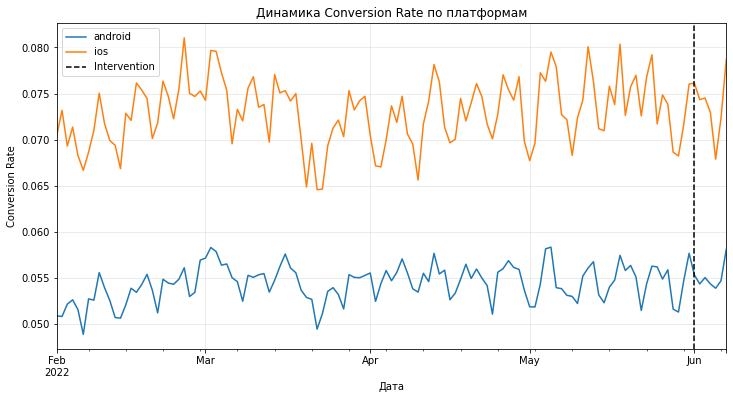

In [6]:
plt.figure(figsize=(12, 6))

df['event_date'] = pd.to_datetime(df['event_date'])
pivot_df = df.pivot(index='event_date', columns='platform', values='cr')

for platform in pivot_df.columns:
    pivot_df[platform].plot(label=platform)

plt.title('Динамика Conversion Rate по платформам')
plt.xlabel('Дата')
plt.ylabel('Conversion Rate')
plt.axvline(x=pd.to_datetime("2022-06-01"), color='black', linestyle='--', label='Intervention')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Задание 3 (1/2)

Оцените, параллельны ли тренды с помощью Критерия Дики-Фуллера.

Укажите среднюю разницу между рядами на pre периоде.

Введите значение в поле ниже с точностью до трех знаков в десятичной части. Используйте точку для разделения целой и дробной части.

#### Статистический критерий Дики-Фуллера проверяет стационарность временого ряда:

$\large H_0:$ ряд нестационарен

$\large H_1:$ ряд стационарен

In [7]:
pivot_df

platform,android,ios
event_date,,
2022-02-01,0.050870,0.070403
2022-02-02,0.050799,0.073174
2022-02-03,0.052139,0.069300
2022-02-04,0.052607,0.071356
2022-02-05,0.051540,0.068276
...,...,...
2022-06-03,0.055020,0.074511
2022-06-04,0.054334,0.072956
2022-06-05,0.053867,0.067880


In [8]:
pivot_df["intervention"] = np.where(pivot_df.index >= "2022-06-01", 1, 0)

In [9]:
pivot_df.head()

platform,android,ios,intervention
event_date,,,
2022-02-01,0.050870,0.070403,0
2022-02-02,0.050799,0.073174,0
2022-02-03,0.052139,0.069300,0
2022-02-04,0.052607,0.071356,0
2022-02-05,0.051540,0.068276,0


### Задание 3 (2/2)

Стационарна ли разница между метрикой и ковариатой во времени?

Средняя разница между рядами на pre периоде равна: -0.019
p-value тест Дики-Фуллера = 0.000000
Разница между метрикой и ковариатой стационарна во времени? -> True


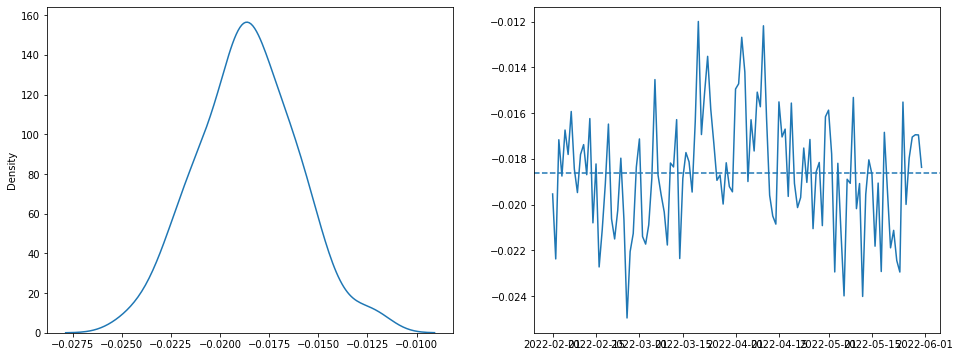

In [10]:
android = pivot_df[pivot_df['intervention'] == 0].android
ios = pivot_df[pivot_df['intervention'] == 0].ios

diff = android - ios

DF_pval = smp.tsa.stattools.adfuller(diff)[1]

print(f"Средняя разница между рядами на pre периоде равна: {round(diff.mean(), 3)}")
print("p-value тест Дики-Фуллера = %f" % DF_pval)
print('Разница между метрикой и ковариатой стационарна во времени? ->', DF_pval < 0.05)
fig,axes = plt.subplots(1, 2, figsize=(16,6))
sns.kdeplot(ax=axes[0], data=diff)
axes[1].plot(diff)
axes[1].axhline(y = np.mean(diff),ls='--')

### Задание 4 (1/3)

Проанализируйте изменения с Diff-in-Diff с контрольной группой android. Отвергается ли нулевая гипотеза?

In [11]:
df["treatment"] = np.where(df['platform'] == "android", 1, 0)  # Обозначаем группу контрольная/тестовая
df["intervention"] = np.where(df['event_date'] >= "2022-06-01", 1, 0)  # Обозначаем дату введения изменения

In [12]:
df_s = df.pivot_table(
    values="cr", index="treatment", columns="intervention", aggfunc="mean"
)

In [13]:
df_s = df.pivot_table(
    values="cr", index="treatment", columns="intervention", aggfunc="mean"
)

df_s["diff"] = df_s.iloc[:, 1] - df_s.iloc[:, 0]  # Вычисление разниц
diff_in_diff = df_s.iloc[1, -1] - df_s.iloc[0, -1]  # Вычисление DiD
diff_in_diff = df_s.iloc[1, -1] - df_s.iloc[0, -1]

print("Diff-in-Diff =", diff_in_diff)
df_s

Diff-in-Diff = -0.00013297244115732104


intervention,0,1,diff
treatment,,,
0,0.072975,0.073835,0.000859
1,0.054363,0.055089,0.000726


In [14]:
formula = 'cr ~ treatment + intervention + treatment * intervention'
model = sm.ols(formula=formula, data=df)
res = model.fit()
print(res.summary())

p_value = res.pvalues['treatment:intervention']
if p_value < 0.05:
    print('H0 отвергается')
else:
    print('H0 не отвергается')

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     905.7
Date:                Wed, 20 Aug 2025   Prob (F-statistic):          6.06e-134
Time:                        14:06:39   Log-Likelihood:                 1130.4
No. Observations:                 254   AIC:                            -2253.
Df Residuals:                     250   BIC:                            -2239.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

### Задание 4 (2/3)

Укажите, чему равно абсолютное изменение Diff-in-Diff.

Введите значение в поле ниже с точностью до пяти знаков в десятичной части. Используйте точку для разделения целой и дробной части.

In [15]:
print('Diff-in-Diff =', round(res.params['treatment:intervention'], 5))

Diff-in-Diff = -0.00013


### Задание 4 (3/3)

Какой был p-value для этого изменения?

Введите значение в поле ниже с точностью до трех знаков в десятичной части. Используйте точку для разделения целой и дробной части.

In [16]:
round(p_value, 3)

0.932

### Задание 5 (1/2)

Проведите симуляцию ошибок I и II рода для эффектов `[0.9, 0.95, 0.975, 1., 1.025, 1.05, 1.1]`, где 1 — нет эффекта.

Используйте следующие параметры для симуляции:

- `ковариата` — 'android'
- `n_days` = 7
- `control_percent` = 0.7
- `n_sim` = 100
- `random_state` в функции оставляем без изменений.

Укажите ошибку II рода для эффекта минус 5%.

Введите значение в поле ниже с точностью до двух знаков в десятичной части. Используйте точку для разделения целой и дробной части.

In [17]:
pivot_df

platform,android,ios,intervention
event_date,,,
2022-02-01,0.050870,0.070403,0
2022-02-02,0.050799,0.073174,0
2022-02-03,0.052139,0.069300,0
2022-02-04,0.052607,0.071356,0
2022-02-05,0.051540,0.068276,0
...,...,...,...
2022-06-03,0.055020,0.074511,1
2022-06-04,0.054334,0.072956,1
2022-06-05,0.053867,0.067880,1


In [24]:
def causal_analysis(data, control_group, n_days = 14, control_percent = 0.7, sample_n = 50):
    '''
    data - наши исторические данные, на которых мы будем прогонять проверку критерия
    control_group - название переменной формирующих контрольную группу
    n_days - количество дней тестового периода. т.е. сколько мы предполагаем будет идти пост-период в днях.
                Задавать нужно так чтобы размер n_days не превышал 1-control_percent долю тестовых данных. Поэтому процент 1-control_percent нужно оставлять с запасом
    control_percent - доля истрических данных, которую мы резервируем для контрольного периода. Например не меньше 70%.
    sample_n - кол-во симмуляций. Сколько раз прогоняем на каждый проверяеммый эффект симмуляции (в коде по умолчанию 7 эффектов)

    '''
    n_days -= 1

    df_copy = data.copy()
    effects = [0.9, 0.95, 0.975, 1., 1.025, 1.05, 1.1] # Эффекты от снижения до увеличения. 1 - эффекта нет = АА вариант
    rel_effects = []

    dates = pd.DataFrame({'post_period_0': data.index}) # Даты

    # Самая первая дата контрольной группы
    initial = dates.values[0][0]
    # Тестовая группа, подбираем из неё sample_n рандомных дат в тестовом периоде, т.е. sample_n дат после control_percent дней.
    # мы как бы рандомно накидываем дни старта нововведения в тестовой зоне
    test = dates.iloc[int(len(dates)*(control_percent)):-n_days]\
                .sample(sample_n, random_state = 123, replace = True)\

    # Определяем пост и пре период в зависимости от полученных рандомных дат в тестовом периоде
    test['post_period_1'] = test.post_period_0 + pd.DateOffset(days = n_days)
    test['pre_period_0'] = initial
    test['pre_period_1'] = test.post_period_0 - pd.DateOffset(days = 1)

    test = test.astype(str)
    a = np.empty((sample_n, len(effects) + 2))

    def calculate_sse_mape_pval(d):
        sse = []
        mape = []
        p_vals = []
        for i in range(len(effects)):
            pre_period = [test.pre_period_0.values[d], test.pre_period_1.values[d]]
            post_period = [test.post_period_0.values[d], test.post_period_1.values[d]]

            # формируем датасеты для оценки эффектов. добавляем нужные эффекты
            df_copy = data.copy() # создаём другую переменную дубликата датафрейма чтобы каждый раз задавать новый эффект

            # указываем когда был intervention
            df_copy['intervention'] = 0
            df_copy.loc[post_period[0]:post_period[1], 'intervention'] = 1

            df_copy.loc[np.logical_and(
                        df_copy.index >= post_period[0], df_copy.index <= post_period[1]), 'y'] *= effects[i] # задаём эффект

            df_copy = pd.melt(df_copy.reset_index(), id_vars = ['index', 'intervention'], value_vars = ['y', control_group],
                 var_name = 'variable', value_name = 'value')
            df_copy['treatment'] = np.where(df_copy.variable == 'y', 1, 0)

            formula = 'value ~ treatment + intervention + treatment * intervention'
            model = sm.ols(formula = formula, data = df_copy)
            res = model.fit()

            b0 = res.params['Intercept']
            b1 = res.params['treatment']
            b2 = res.params['intervention']
            b3 = res.params['treatment:intervention']

            # Понимая как устроен Diff-in-Diff, можем с регрессии вычислить относительное изменение diff-in-diff
            rel_diff_in_diff = ((b0 + b1 + b2 + b3) / (b0 + b1)) / ((b0 + b2) / b0) - 1

            real_eff = effects[i] - 1
            to_sse = pow(rel_diff_in_diff - real_eff, 2) # считаем квадрат ошибок нашего нафденного diff-in-diff и реального
            to_mape = abs(rel_diff_in_diff - real_eff) * 100 # считаем квадрат ошибок нашего нафденного diff-in-diff и реального

            sse.append(to_sse)
            mape.append(to_mape)
            rel_effects.append(rel_diff_in_diff)
            p_vals.append(res.pvalues['treatment:intervention'])

        return (d, sum(sse), np.mean(mape), p_vals[effects.index(1)], p_vals[effects.index(1.025)],
               p_vals[effects.index(0.975)], p_vals[effects.index(1.05)], p_vals[effects.index(0.95)],
               p_vals[effects.index(1.1)], p_vals[effects.index(0.9)])

    results = joblib.Parallel(n_jobs=-1, verbose = len(test))(joblib.delayed(calculate_sse_mape_pval)(d) for d in range(len(test)))

    for result in results:
        d = result[0]
        a[d][0] = result[1]
        a[d][1] = result[2]
        a[d][2] = result[3]
        a[d][3] = result[4]
        a[d][4] = result[5]
        a[d][5] = result[6]
        a[d][6] = result[7]
        a[d][7] = result[8]
        a[d][8] = result[9]

    aa = pd.DataFrame(a, columns = ['sse', 'mape', 'p_val_1', 'p_val_1_025', 'p_val_0_975',
                                    'p_val_1_05', 'p_val_0_95', 'p_val_1_1', 'p_val_0_9'])
    final = test.reset_index().merge(aa.reset_index(), left_index = True, right_index = True)
    final.drop(columns = ['index_x', 'index_y'], inplace = True)
    final['control_group'] = control_group
    return final

In [25]:
ts_data = df.query("event_date < '2022-06-01'")\
              .pivot_table(values = 'cr', index = 'event_date', columns = 'platform')
ts_data.rename(columns = {'ios': 'y'}, inplace = True)
ts_data.index.name = None

In [26]:
n_sim = 100
res = pd.DataFrame()
caus = causal_analysis(ts_data, 'android', 7, 0.7, n_sim)
res = pd.concat([res, caus], axis = 0)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

In [27]:
def to_res(data, to_group, n, alpha = 0.05):
    def p_val_count_alpha(p_val):
        return np.count_nonzero(p_val < alpha)

    def p_val_count_beta(p_val):
        return np.count_nonzero(p_val >= alpha)

    p_val_cols = data.filter(like = 'p_val').columns

    data['pre_period_diff'] = (pd.to_datetime(data.pre_period_1) - pd.to_datetime(data.pre_period_0))
    res = data.groupby([to_group]).agg({'sse': 'sum',
                                     'mape': 'mean',
                                     p_val_cols[0]: p_val_count_alpha,
                                     p_val_cols[1]: p_val_count_beta,
                                     p_val_cols[2]: p_val_count_beta,
                                     p_val_cols[3]: p_val_count_beta,
                                     p_val_cols[4]: p_val_count_beta,
                                     p_val_cols[5]: p_val_count_beta,
                                     p_val_cols[6]: p_val_count_beta,
                                     'pre_period_diff': 'mean'})

    res[p_val_cols[0]] = res[p_val_cols[0]] / n
    res[p_val_cols[1]] = res[p_val_cols[1]] / n
    res[p_val_cols[2]] = res[p_val_cols[2]] / n
    res[p_val_cols[3]] = res[p_val_cols[3]] / n
    res[p_val_cols[4]] = res[p_val_cols[4]] / n
    res[p_val_cols[5]] = res[p_val_cols[5]] / n
    res[p_val_cols[6]] = res[p_val_cols[6]] / n

    return res

res_conc = to_res(res, 'control_group', n_sim)

print('Ошибка II рода для -5% =', res_conc.p_val_0_95.values[0].round(3))

Ошибка II рода для -5% = 0.72


### Задание 5 (2/2)

Какой будет оценка ошибки I рода?

Введите значение в поле ниже с точностью до одного знака в десятичной части. Используйте точку для разделения целой и дробной части.

In [30]:
print('Ошибка I рода =', res_conc.p_val_1.values[0].round(3))

Ошибка I рода = 0.0
